<a href="https://colab.research.google.com/github/UzunDemir/ML_Junior_diplom_project_Skillbox/blob/main/research_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# для работающих в Google Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pyspark --quiet
!pip install -U -q PyDrive --quiet
!apt install openjdk-8-jdk-headless &> /dev/null

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip &> /dev/null
!unzip ngrok-stable-linux-amd64.zip &> /dev/null
get_ipython().system_raw('./ngrok http 4050 &')

In [ ]:
from pyspark.sql import SparkSession


### Ваш код здесь ###
spark = SparkSession.builder\
        .master("local[*]")\
        .appName('bank')\
        .getOrCreate()

In [ ]:
# Считывание данных из файла targets.csv в датафрейм Spark
tar_df = spark.read.csv("/content/drive/MyDrive/Colab Notebooks/Final_project_course “ML_ Junior”/merged_data.csv", header=True, inferSchema=True)

# Вывод схемы данных
tar_df.printSchema()

# Вывод первых нескольких строк данных
tar_df.show(5)


root
 |-- id: integer (nullable = true)
 |-- rn: integer (nullable = true)
 |-- pre_since_opened: integer (nullable = true)
 |-- pre_since_confirmed: integer (nullable = true)
 |-- pre_pterm: integer (nullable = true)
 |-- pre_fterm: integer (nullable = true)
 |-- pre_till_pclose: integer (nullable = true)
 |-- pre_till_fclose: integer (nullable = true)
 |-- pre_loans_credit_limit: integer (nullable = true)
 |-- pre_loans_next_pay_summ: integer (nullable = true)
 |-- pre_loans_outstanding: integer (nullable = true)
 |-- pre_loans_total_overdue: integer (nullable = true)
 |-- pre_loans_max_overdue_sum: integer (nullable = true)
 |-- pre_loans_credit_cost_rate: integer (nullable = true)
 |-- pre_loans5: integer (nullable = true)
 |-- pre_loans530: integer (nullable = true)
 |-- pre_loans3060: integer (nullable = true)
 |-- pre_loans6090: integer (nullable = true)
 |-- pre_loans90: integer (nullable = true)
 |-- is_zero_loans5: integer (nullable = true)
 |-- is_zero_loans530: integer (nul

In [ ]:
# Количество строк
row_count = tar_df.count()
print("Количество строк:", row_count)

# Количество столбцов
column_count = len(tar_df.columns)
print("Количество столбцов:", column_count)


Количество строк: 3000000
Количество столбцов: 62


In [ ]:
# Импорт необходимых библиотек
from pyspark.sql.functions import col

# Группировка по столбцу 'flag' и подсчет количества в каждой группе
flag_counts = tar_df.groupBy('flag').count().orderBy('count', ascending=False)

# Вывод результатов
flag_counts.show()


+----+-------+
|flag|  count|
+----+-------+
|   0|2893558|
|   1| 106442|
+----+-------+



In [ ]:
# Импорт необходимых библиотек
from pyspark.sql.functions import col

# Группировка по столбцу 'flag' и подсчет количества в каждой группе
flag_counts = tar_df.groupBy('flag').count().orderBy('count', ascending=False)

# Вывод результатов
flag_counts.show()

# Вычисление общего количества строк
total_count = tar_df.count()

# Вывод общего количества строк
print("Общее количество строк:", total_count)


+----+-------+
|flag|  count|
+----+-------+
|   0|2893558|
|   1| 106442|
+----+-------+

Общее количество строк: 3000000


### Исследования на 10% датафрейме

In [ ]:
from pyspark.sql.functions import count, sum

# Группировка данных по столбцу "flag" и подсчет количества вхождений каждого значения
flag_counts = tar_df.groupBy("flag").agg(count("*").alias("count"))

# Вычисление общего количества записей
total_count = flag_counts.agg(sum("count").alias("total_count")).collect()[0]["total_count"]

# Создание строки с общим количеством
total_row = spark.createDataFrame([("Total", total_count)], ["flag", "count"])

# Объединение таблицы с подсчетами и строкой с общим количеством
flag_counts_with_total = flag_counts.union(total_row)

# Вывод результатов
flag_counts_with_total.show()


+-----+-------+
| flag|  count|
+-----+-------+
|    1| 106442|
|    0|2893558|
|Total|3000000|
+-----+-------+



In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, sum

def count_values_and_total(df, column_name):
    """
    Подсчитывает количество вхождений каждого значения в указанном столбце DataFrame и добавляет строку с общим
    количеством записей внизу таблицы.

    Аргументы:
    - df: DataFrame, в котором производится подсчет
    - column_name: str, имя столбца, для которого производится подсчет

    Возвращает:
    - DataFrame с подсчитанными значениями и строкой с общим количеством записей
    """
    # Группировка данных по указанному столбцу и подсчет количества вхождений каждого значения
    column_counts = df.groupBy(column_name).agg(count("*").alias("count"))

    # Вычисление общего количества записей
    total_count = column_counts.agg(sum("count").alias("total_count")).collect()[0]["total_count"]

    # Создание строки с общим количеством
    total_row = SparkSession.builder.getOrCreate().createDataFrame([("Total", total_count)], [column_name, "count"])

    # Объединение таблицы с подсчетами и строкой с общим количеством
    column_counts_with_total = column_counts.union(total_row)

    return column_counts_with_total

# Пример использования:
# result_df = count_values_and_total(tar_df, "flag")
# result_df.show()


In [ ]:
def count_values_and_total(df, column_name):
    """
    Подсчитывает количество вхождений каждого значения в указанном столбце DataFrame,
    сортирует результаты по столбцу в порядке возрастания и добавляет строку с общим
    количеством записей внизу таблицы.

    Аргументы:
    - df: DataFrame, в котором производится подсчет
    - column_name: str, имя столбца, для которого производится подсчет

    Возвращает:
    - DataFrame с подсчитанными значениями, отсортированными по столбцу, и строкой с общим количеством записей
    """
    # Группировка данных по указанному столбцу и подсчет количества вхождений каждого значения
    column_counts = df.groupBy(column_name).agg(count("*").alias("count"))

    # Сортировка результатов по столбцу в порядке возрастания
    column_counts_sorted = column_counts.orderBy(column_name)

    # Вычисление общего количества записей
    total_count = df.count()

    # Создание строки с общим количеством
    total_row = SparkSession.builder.getOrCreate().createDataFrame([("Total", total_count)], [column_name, "count"])

    # Объединение таблицы с подсчетами и строкой с общим количеством
    column_counts_with_total = column_counts_sorted.union(total_row)

    return column_counts_with_total

# Пример использования:
# result_df = count_values_and_total(tar_df, "flag")
# result_df.show()


In [ ]:
tar_df.columns

In [ ]:
result_df = count_values_and_total(tar_df, "pre_since_opened")
result_df.show()


In [ ]:
result_df.show(60)

In [ ]:
from pyspark.sql import SparkSession

def crosstab_values(df, column1, column2):
    """
    Выводит взаимосвязь между значениями двух столбцов DataFrame в виде кросс-таблицы.

    Аргументы:
    - df: DataFrame, в котором производится анализ
    - column1: str, имя первого столбца
    - column2: str, имя второго столбца

    Возвращает:
    - DataFrame с кросс-таблицей, отображающей взаимосвязь между значениями двух столбцов
    """
    # Выполняем кросс-таблицу для указанных столбцов
    crosstab_df = df.crosstab(column1, column2)

    return crosstab_df

# Пример использования:
# spark = SparkSession.builder.getOrCreate()
# crosstab_df = crosstab_values(df, "column1", "column2")
# crosstab_df.show()


In [ ]:

crosstab_df = crosstab_values(tar_df, "pre_since_opened", "flag")
crosstab_df.show()

In [ ]:
from pyspark.sql import SparkSession

def crosstab_values(df, column1, column2):
    """
    Выводит взаимосвязь между значениями двух столбцов DataFrame в виде кросс-таблицы,
    отсортированной по последнему столбцу в порядке убывания.

    Аргументы:
    - df: DataFrame, в котором производится анализ
    - column1: str, имя первого столбца
    - column2: str, имя второго столбца

    Возвращает:
    - DataFrame с кросс-таблицей, отображающей взаимосвязь между значениями двух столбцов
    """
    # Выполняем кросс-таблицу для указанных столбцов
    crosstab_df = df.crosstab(column1, column2)

    # Сортируем кросс-таблицу по последнему столбцу в порядке убывания
    sorted_crosstab_df = crosstab_df.orderBy(crosstab_df.columns[-1], ascending=False)

    return sorted_crosstab_df

# Пример использования:
# spark = SparkSession.builder.getOrCreate()
# crosstab_df = crosstab_values(df, "column1", "column2")
# crosstab_df.show()


In [ ]:

crosstab_df = crosstab_values(tar_df, "pre_since_confirmed", "flag")
crosstab_df.show()

In [ ]:

crosstab_df = crosstab_values(tar_df, "pre_pterm", "flag")
crosstab_df.show()

In [ ]:
# Импорт библиотеки Spark
from pyspark.sql import SparkSession

# Создание сессии Spark
spark = SparkSession.builder \
    .appName("Sample Data") \
    .getOrCreate()

# Процент выборки
sample_fraction = 0.1

# Выборка данных с соблюдением пропорции значений в столбце "flag"
sampled_df = tar_df.sampleBy("flag", fractions={0: sample_fraction, 1: sample_fraction}, seed=42)

# Вывод размера выборки
print("Размер выборки:", sampled_df.count())


In [ ]:
# Импорт библиотеки pyspark.sql.functions для работы с функциями
from pyspark.sql.functions import col

# Соотношение данных в столбце "flag" в исходном датафрейме
original_flag_ratio = tar_df.groupBy("flag").count().orderBy("flag")

# Соотношение данных в столбце "flag" в созданной выборке
sampled_flag_ratio = sampled_df.groupBy("flag").count().orderBy("flag")

# Вывод результатов
print("Соотношение данных в столбце 'flag' в исходном датафрейме:")
original_flag_ratio.show()

print("Соотношение данных в столбце 'flag' в созданной выборке:")
sampled_flag_ratio.show()


In [ ]:
# Преобразование DataFrame sampled_flag_ratio из Spark в Pandas DataFrame
sampled_df_pandas = sampled_df.toPandas()

# Вывод Pandas DataFrame
sampled_df_pandas


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(sampled_df_pandas.drop('flag', axis=1), sampled_df_pandas['flag'], test_size=0.2, random_state=42)

# Создание модели случайного леса
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Обучение модели на обучающем наборе данных
rf_model.fit(X_train, y_train)

# Прогнозирование на тестовом наборе данных
y_pred = rf_model.predict(X_test)

# Оценка производительности модели
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Вывод отчета о классификации
print("Classification Report:")
print(classification_report(y_test, y_pred))


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

# Создание и обучение модели градиентного бустинга
gb_classifier = GradientBoostingClassifier()
gb_classifier.fit(X_train, y_train)

# Предсказание на тестовом наборе данных
y_pred_gb = gb_classifier.predict(X_test)

# Вывод отчета о классификации
print("Gradient Boosting Classifier Report:")
print(classification_report(y_test, y_pred_gb))


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Создание и обучение модели логистической регрессии
log_reg_classifier = LogisticRegression()
log_reg_classifier.fit(X_train, y_train)

# Предсказание на тестовом наборе данных
y_pred_log_reg = log_reg_classifier.predict(X_test)

# Вывод отчета о классификации
print("Logistic Regression Classifier Report:")
print(classification_report(y_test, y_pred_log_reg))


In [ ]:
import xgboost as xgb
from sklearn.metrics import classification_report

# Преобразование данных в формат, подходящий для XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Задание параметров модели XGBoost
params = {
    'max_depth': 3,  # Максимальная глубина деревьев
    'eta': 0.1,  # Шаг обучения (learning rate)
    'objective': 'binary:logistic',  # Функция потерь
    'eval_metric': 'logloss'  # Метрика качества
}

# Обучение модели XGBoost
num_rounds = 100  # Количество итераций (деревьев)
xgb_model = xgb.train(params, dtrain, num_rounds)

# Предсказание на тестовом наборе данных
y_pred_xgb = xgb_model.predict(dtest)

# Преобразование вероятностей в метки классов (0 или 1)
y_pred_xgb_binary = [1 if p >= 0.5 else 0 for p in y_pred_xgb]

# Вывод отчета о классификации
print("XGBoost Classifier Report:")
print(classification_report(y_test, y_pred_xgb_binary))


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

# Создание модели XGBoost
xgb_model = XGBClassifier()

# Задание сетки параметров для перебора
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 300, 500],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.5, 0.7, 0.9],
    'colsample_bytree': [0.5, 0.7, 0.9]
}

# Создание объекта RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid, n_iter=50, scoring='accuracy', cv=3, verbose=2, random_state=42)

# Обучение модели на обучающих данных
random_search.fit(X_train, y_train)

# Вывод лучших параметров
print("Best parameters found:", random_search.best_params_)

# Получение лучшей модели
best_xgb_model = random_search.best_estimator_

# Оценка лучшей модели на тестовых данных
y_pred_best_xgb = best_xgb_model.predict(X_test)

# Вывод отчета о классификации
print("Best XGBoost Classifier Report:")
print(classification_report(y_test, y_pred_best_xgb))


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(sampled_df_pandas.drop('flag', axis=1), sampled_df_pandas['flag'], test_size=0.2, random_state=42)

# Создание модели случайного леса
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

# Обучение модели на обучающем наборе данных
rf_model.fit(X_train, y_train)

# Прогнозирование на тестовом наборе данных
y_pred = rf_model.predict(X_test)

# Оценка производительности модели
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Вывод отчета о классификации
print("Classification Report:")
print(classification_report(y_test, y_pred))


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Создание и обучение модели логистической регрессии
log_reg_classifier = LogisticRegression(class_weight='balanced')
log_reg_classifier.fit(X_train, y_train)

# Предсказание на тестовом наборе данных
y_pred_log_reg = log_reg_classifier.predict(X_test)

# Вывод отчета о классификации
print("Logistic Regression Classifier Report:")
print(classification_report(y_test, y_pred_log_reg))


### Иссследования

In [ ]:
numeric_columns = tar_df.columns[0:10]

In [ ]:
from pyspark.sql.functions import corr

# Вычисляем корреляцию между всеми числовыми признаками в DataFrame
correlation_matrix = tar_df.select([corr(col1, col2).alias(f'corr_{col1}_{col2}')
                                    for col1 in numeric_columns
                                    for col2 in numeric_columns]).show()


+----------+----------+------------------------+---------------------------+--------------------+--------------------+-----------------------+-----------------------+------------------------------+-------------------------------+----------+----------+------------------------+---------------------------+-----------------+-----------------+-----------------------+-----------------------+------------------------------+-------------------------------+------------------------+------------------------+--------------------------------------+-----------------------------------------+-------------------------------+-------------------------------+-------------------------------------+-------------------------------------+--------------------------------------------+---------------------------------------------+---------------------------+---------------------------+-----------------------------------------+--------------------------------------------+----------------------------------+---------

In [ ]:
import pandas as pd

# Предположим, что у вас есть DataFrame tar_df в Spark

# Преобразование DataFrame из Spark в DataFrame Pandas
pandas_df = tar_df.toPandas()

# Теперь pandas_df - это обычный DataFrame в Pandas


Py4JJavaError: An error occurred while calling o31.collectToPython.
: java.lang.OutOfMemoryError: GC overhead limit exceeded
	at org.apache.spark.sql.execution.SparkPlan$$anon$1._next(SparkPlan.scala:417)
	at org.apache.spark.sql.execution.SparkPlan$$anon$1.getNext(SparkPlan.scala:426)
	at org.apache.spark.sql.execution.SparkPlan$$anon$1.getNext(SparkPlan.scala:412)
	at org.apache.spark.util.NextIterator.hasNext(NextIterator.scala:73)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.util.NextIterator.foreach(NextIterator.scala:21)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeCollect$1(SparkPlan.scala:449)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeCollect$1$adapted(SparkPlan.scala:448)
	at org.apache.spark.sql.execution.SparkPlan$$Lambda$3432/1499967722.apply(Unknown Source)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.ArrayOps$ofRef.foreach(ArrayOps.scala:198)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:448)
	at org.apache.spark.sql.Dataset.$anonfun$collectToPython$1(Dataset.scala:4148)
	at org.apache.spark.sql.Dataset$$Lambda$3728/1611646724.apply(Unknown Source)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:4322)
	at org.apache.spark.sql.Dataset$$Lambda$2047/2024690842.apply(Unknown Source)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:546)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:4320)
	at org.apache.spark.sql.Dataset$$Lambda$1699/661130360.apply(Unknown Source)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$$$Lambda$1710/1009232335.apply(Unknown Source)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.execution.SQLExecution$$$Lambda$1700/991044699.apply(Unknown Source)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:4320)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:4145)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)


In [ ]:
# Преобразование DataFrame sampled_flag_ratio из Spark в Pandas DataFrame
sampled_df_pandas = sampled_df.toPandas()

# Вывод Pandas DataFrame
sampled_df_pandas


In [ ]:
# Импорт библиотеки Spark
from pyspark.sql import SparkSession

# Создание сессии Spark
spark = SparkSession.builder \
    .appName("Sample Data") \
    .getOrCreate()

# Процент выборки
sample_fraction = 0.1

# Выборка данных с соблюдением пропорции значений в столбце "flag"
sampled_df = tar_df.sampleBy("flag", fractions={0: sample_fraction, 1: sample_fraction}, seed=42)

# Вывод размера выборки
print("Размер выборки:", sampled_df.count())

Размер выборки: 299508


In [ ]:
# Преобразование DataFrame sampled_flag_ratio из Spark в Pandas DataFrame
sampled_df_pandas = sampled_df.toPandas()

# Вывод Pandas DataFrame
sampled_df_pandas

,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,...,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag,flag
0,61,1,0,3,17,14,3,10,6,2,...,1,1,1,1,3,4,1,0,0,0
1,106,1,10,4,3,5,6,13,5,2,...,3,3,4,1,3,4,1,0,0,0
2,111,1,13,12,4,8,1,11,4,2,...,3,3,4,1,3,3,1,1,1,0
3,292,1,8,14,14,16,13,13,0,2,...,3,3,4,1,3,4,1,0,0,0
4,322,1,8,7,13,2,9,1,1,2,...,3,3,4,1,3,4,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299503,2999750,1,12,3,4,8,1,11,4,2,...,3,3,4,4,1,1,1,1,1,0
299504,2999807,1,6,8,16,15,5,10,12,2,...,3,3,4,1,3,7,1,0,0,0
299505,2999813,1,16,7,13,2,4,9,3,2,...,3,3,4,1,3,4,1,0,0,0
299506,2999839,1,11,9,4,8,1,11,19,6,...,3,3,4,1,2,4,1,1,1,0


In [ ]:
sampled_df_pandas['flag'].value_counts()

0    288801
1     10707
Name: flag, dtype: int64

In [ ]:
# Создание двух выборок: одна с flag=1, другая с flag=0
sampled_df_flag1 = tar_df.filter(tar_df.flag == 1)
sampled_df_flag0 = tar_df.filter(tar_df.flag == 0)

# Подсчет количества значений flag=1
count_flag1 = sampled_df_flag1.count()

# Создание выборки с flag=0, используя количества значений flag=1
sampled_df_flag0_balanced = sampled_df_flag0.limit(count_flag1)

# Объединение двух выборок
balanced_sampled_df = sampled_df_flag1.union(sampled_df_flag0_balanced)


In [ ]:
from pyspark.sql.functions import count, sum

# Группировка данных по столбцу "flag" и подсчет количества вхождений каждого значения
flag_counts = balanced_sampled_df.groupBy("flag").agg(count("*").alias("count"))

# Вычисление общего количества записей
total_count = flag_counts.agg(sum("count").alias("total_count")).collect()[0]["total_count"]

# Создание строки с общим количеством
total_row = spark.createDataFrame([("Total", total_count)], ["flag", "count"])

# Объединение таблицы с подсчетами и строкой с общим количеством
flag_counts_with_total = flag_counts.union(total_row)

# Вывод результатов
flag_counts_with_total.show()


+-----+------+
| flag| count|
+-----+------+
|    1|106442|
|    0|106442|
|Total|212884|
+-----+------+



In [ ]:
# Путь для сохранения 10% выборки
sampled_df_10_percent_path = "/content/drive/MyDrive/Colab Notebooks/Final_project_course “ML_ Junior”/df_90_10/sampled_df_10_percent.parquet"

# Сохранение 10% выборки в формате Parquet
sampled_df.write.mode("overwrite").parquet(sampled_df_10_percent_path)

# Фильтрация исходного DataFrame для создания 90% выборки
rest_of_data_df = tar_df.subtract(sampled_df)

# Путь для сохранения 90% выборки
rest_of_data_path = "/content/drive/MyDrive/Colab Notebooks/Final_project_course “ML_ Junior”/df_90_10/rest_of_data.parquet"

# Сохранение оставшихся данных (90% выборки) в формате Parquet
rest_of_data_df.write.mode("overwrite").parquet(rest_of_data_path)

print("10% выборка сохранена в:", sampled_df_10_percent_path)
print("90% выборка сохранена в:", rest_of_data_path)


10% выборка сохранена в: /content/drive/MyDrive/Colab Notebooks/Final_project_course “ML_ Junior”/df_90_10/sampled_df_10_percent.parquet
90% выборка сохранена в: /content/drive/MyDrive/Colab Notebooks/Final_project_course “ML_ Junior”/df_90_10/rest_of_data.parquet


In [ ]:
# Путь к файлу Parquet
parquet_file_path = "/content/drive/MyDrive/Colab Notebooks/Final_project_course “ML_ Junior”/df_90_10/rest_of_data.parquet"

# Загрузка данных из файла Parquet в DataFrame
rest_of_data_df = spark.read.parquet(parquet_file_path)

# Проверка размера DataFrame
print("Размер загруженного DataFrame:", rest_of_data_df.count())


Размер загруженного DataFrame: 2700492


In [ ]:
from pyspark.sql.functions import count, sum

# Группировка данных по столбцу "flag" и подсчет количества вхождений каждого значения
flag_counts = rest_of_data_df.groupBy("flag").agg(count("*").alias("count"))

# Вычисление общего количества записей
total_count = flag_counts.agg(sum("count").alias("total_count")).collect()[0]["total_count"]

# Создание строки с общим количеством
total_row = spark.createDataFrame([("Total", total_count)], ["flag", "count"])

# Объединение таблицы с подсчетами и строкой с общим количеством
flag_counts_with_total = flag_counts.union(total_row)

# Вывод результатов
flag_counts_with_total.show()


+-----+-------+
| flag|  count|
+-----+-------+
|    1|  95735|
|    0|2604757|
|Total|2700492|
+-----+-------+



In [ ]:
# Путь к файлу Parquet
parquet_file_path = "/content/drive/MyDrive/Colab Notebooks/Final_project_course “ML_ Junior”/df_90_10/sampled_df_10_percent.parquet"

# Загрузка данных из файла Parquet в DataFrame
df_10_percent = spark.read.parquet(parquet_file_path)

# Проверка размера DataFrame
print("Размер загруженного DataFrame:", df_10_percent.count())


Размер загруженного DataFrame: 299508


In [ ]:
from pyspark.sql.functions import count, sum

# Группировка данных по столбцу "flag" и подсчет количества вхождений каждого значения
flag_counts = df_10_percent.groupBy("flag").agg(count("*").alias("count"))

# Вычисление общего количества записей
total_count = flag_counts.agg(sum("count").alias("total_count")).collect()[0]["total_count"]

# Создание строки с общим количеством
total_row = spark.createDataFrame([("Total", total_count)], ["flag", "count"])

# Объединение таблицы с подсчетами и строкой с общим количеством
flag_counts_with_total = flag_counts.union(total_row)

# Вывод результатов
flag_counts_with_total.show()


+-----+------+
| flag| count|
+-----+------+
|    1| 10707|
|    0|288801|
|Total|299508|
+-----+------+



In [ ]:
rest_of_data_df.show()

+-----+---+----------------+-------------------+---------+---------+---------------+---------------+----------------------+-----------------------+---------------------+-----------------------+-------------------------+--------------------------+----------+------------+-------------+-------------+-----------+--------------+----------------+-----------------+-----------------+---------------+--------+--------------+-----------------+------------+------------------+---------------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------------------------+-----------------------+---------------------+---------------------+-----------+-----------+----+
|   id| rn|pre_since_opened|pre_since_confirmed|pre_pterm|pre_fterm|pre_till_pclose|pre_till

In [ ]:
# Создание двух выборок: одна с flag=1, другая с flag=0
sampled_df_flag1 = rest_of_data_df.filter(rest_of_data_df.flag == 1)
sampled_df_flag0 = rest_of_data_df.filter(rest_of_data_df.flag == 0)

# Подсчет количества значений flag=1
count_flag1 = sampled_df_flag1.count()

# Создание выборки с flag=0, используя количества значений flag=1
sampled_df_flag0_balanced = sampled_df_flag0.limit(count_flag1)

# Объединение двух выборок
balanced_df = sampled_df_flag1.union(sampled_df_flag0_balanced)


In [ ]:
from pyspark.sql.functions import count, sum

# Группировка данных по столбцу "flag" и подсчет количества вхождений каждого значения
flag_counts = balanced_df.groupBy("flag").agg(count("*").alias("count"))

# Вычисление общего количества записей
total_count = flag_counts.agg(sum("count").alias("total_count")).collect()[0]["total_count"]

# Создание строки с общим количеством
total_row = spark.createDataFrame([("Total", total_count)], ["flag", "count"])

# Объединение таблицы с подсчетами и строкой с общим количеством
flag_counts_with_total = flag_counts.union(total_row)

# Вывод результатов
flag_counts_with_total.show()

+-----+------+
| flag| count|
+-----+------+
|    1| 95735|
|    0| 95735|
|Total|191470|
+-----+------+



In [ ]:
df = balanced_df.toPandas()

In [ ]:
df

,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,...,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag,flag
0,29342,1,15,3,13,0,9,1,6,2,...,3,3,4,1,3,1,1,0,0,1
1,33040,1,0,1,0,7,15,14,0,2,...,3,3,4,1,4,4,1,0,0,1
2,41844,1,15,4,12,14,6,3,16,2,...,3,3,4,1,3,4,1,0,0,1
3,53091,1,9,9,4,8,1,11,6,6,...,3,3,4,1,2,3,1,1,1,1
4,75393,1,17,17,16,9,15,14,6,2,...,3,3,4,1,3,4,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191465,400392,1,6,10,0,8,8,11,0,2,...,0,0,1,1,2,3,1,0,1,0
191466,400395,1,8,12,4,8,1,11,4,2,...,3,3,4,1,3,3,1,1,1,0
191467,400397,1,15,9,16,9,9,13,19,6,...,3,3,4,1,3,4,1,0,0,0
191468,400401,1,17,6,4,2,1,0,12,1,...,3,3,4,1,3,3,1,1,0,0


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Построение корреляционной матрицы
correlation_matrix = df.corr()

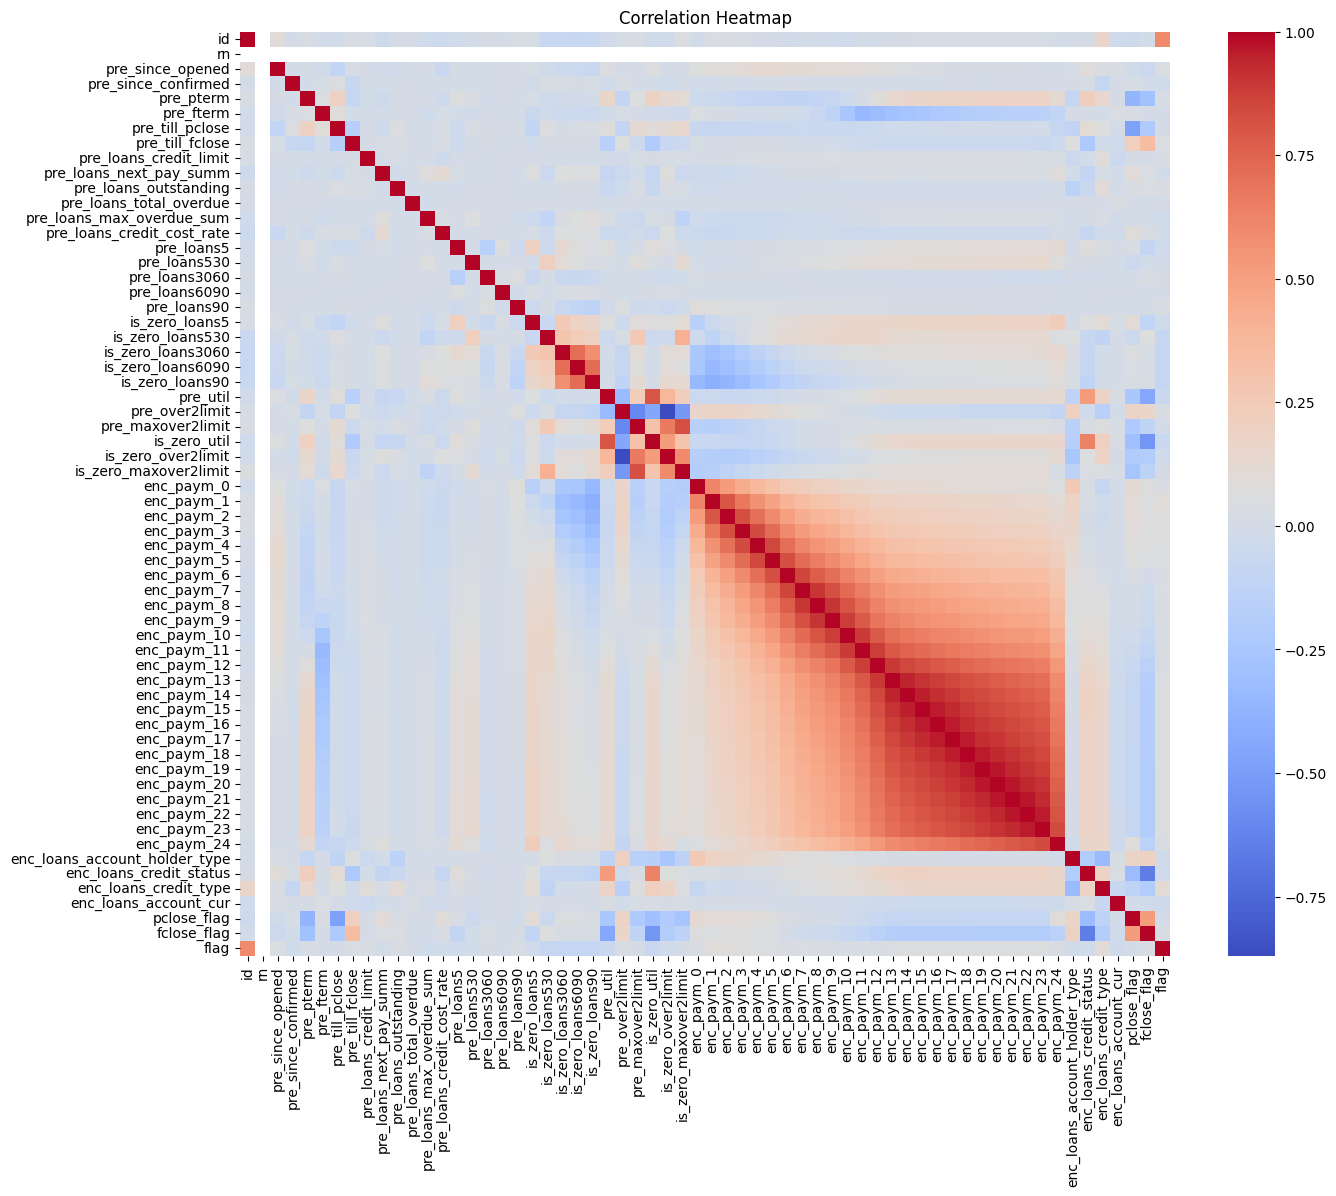

In [ ]:
# Построение тепловой карты
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

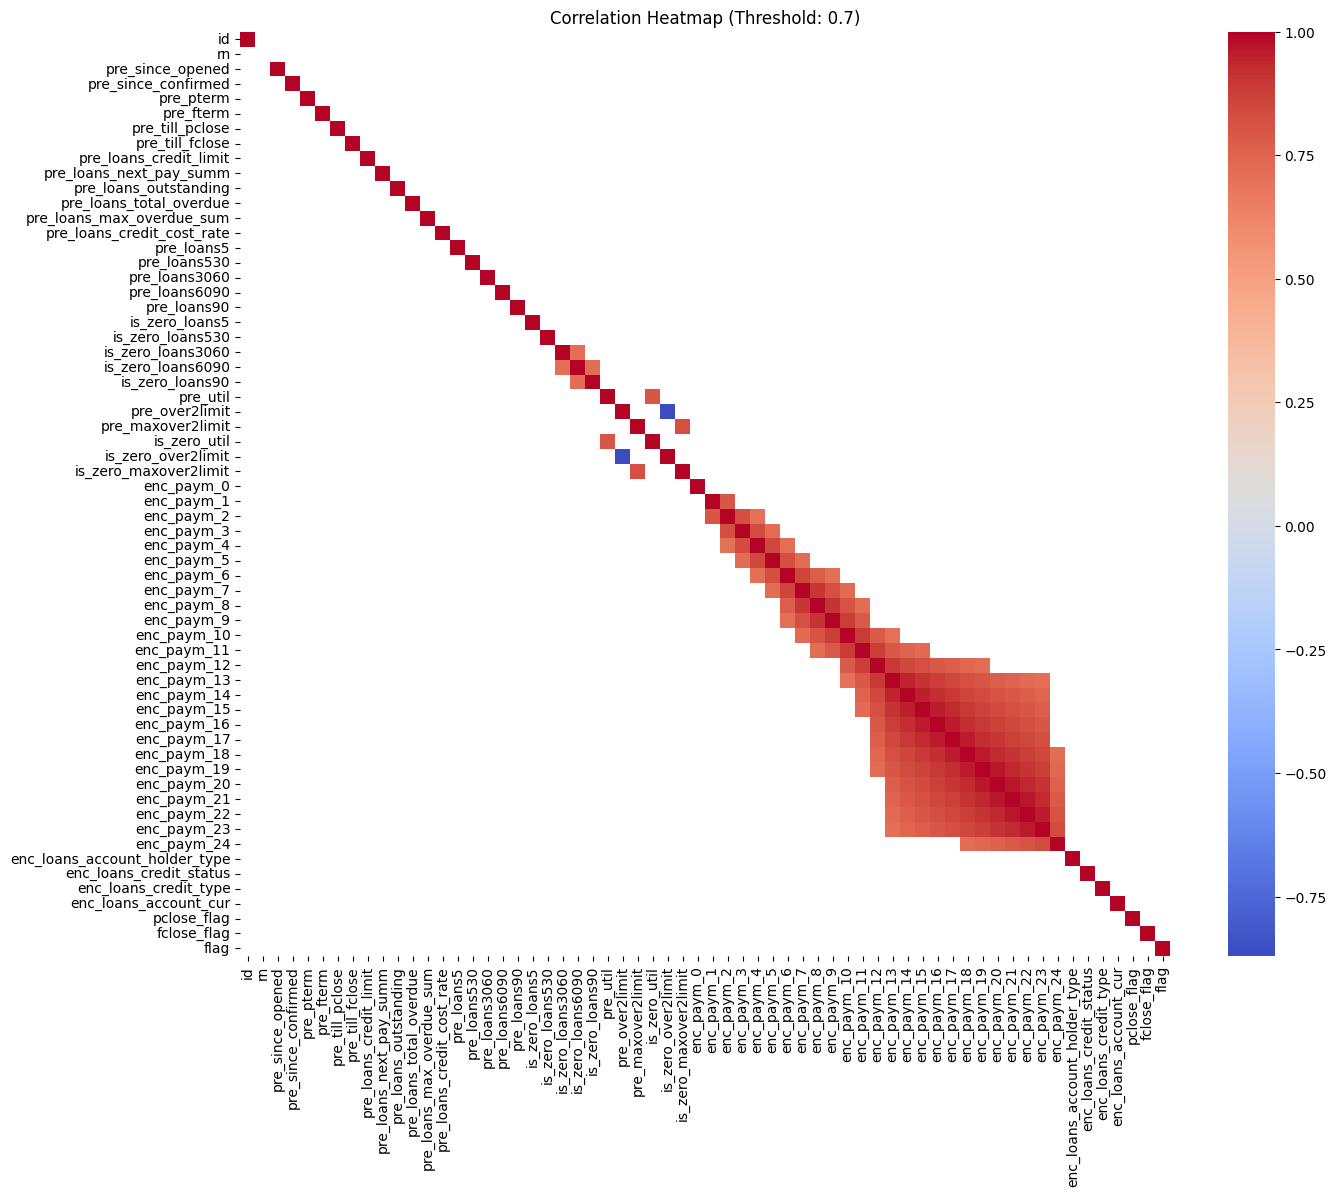

In [ ]:
# Установка порога корреляции
threshold = 0.7

# Создание маски для ячеек с корреляцией выше порога
mask = correlation_matrix.abs() > threshold

# Построение тепловой карты с учетом маски
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix[mask], annot=False, cmap='coolwarm', fmt=".2f")
plt.title(f'Correlation Heatmap (Threshold: {threshold})')
plt.show()


In [ ]:
# Установка порога корреляции
threshold = 0.7

# Создание маски для ячеек с корреляцией выше порога
mask = correlation_matrix.abs() > threshold

# Получение признаков с большой корреляцией
high_correlation_features = []

for column in mask.columns:
    correlated_features = list(filter(lambda x: x != column, mask.index[mask[column]]))
    if correlated_features:
        high_correlation_features.append((column, correlated_features))

# Вывод признаков с большой корреляцией
for feature, correlated_features in high_correlation_features:
    print(f"Признак '{feature}' имеет корреляцию с признаками: {correlated_features}")


Признак 'is_zero_loans3060' имеет корреляцию с признаками: ['is_zero_loans6090']
Признак 'is_zero_loans6090' имеет корреляцию с признаками: ['is_zero_loans3060', 'is_zero_loans90']
Признак 'is_zero_loans90' имеет корреляцию с признаками: ['is_zero_loans6090']
Признак 'pre_util' имеет корреляцию с признаками: ['is_zero_util']
Признак 'pre_over2limit' имеет корреляцию с признаками: ['is_zero_over2limit']
Признак 'pre_maxover2limit' имеет корреляцию с признаками: ['is_zero_maxover2limit']
Признак 'is_zero_util' имеет корреляцию с признаками: ['pre_util']
Признак 'is_zero_over2limit' имеет корреляцию с признаками: ['pre_over2limit']
Признак 'is_zero_maxover2limit' имеет корреляцию с признаками: ['pre_maxover2limit']
Признак 'enc_paym_1' имеет корреляцию с признаками: ['enc_paym_2']
Признак 'enc_paym_2' имеет корреляцию с признаками: ['enc_paym_1', 'enc_paym_3', 'enc_paym_4']
Признак 'enc_paym_3' имеет корреляцию с признаками: ['enc_paym_2', 'enc_paym_4', 'enc_paym_5']
Признак 'enc_paym_4' 

In [ ]:
correlated_list = ['is_zero_loans3060', 'is_zero_loans90', 'is_zero_util', 'is_zero_over2limit'] + enc_paym_10


In [ ]:
enc_paym_10 = ['enc_paym_' + str(i) for i in range(2, 25)]
print(enc_paym_10)


['enc_paym_2', 'enc_paym_3', 'enc_paym_4', 'enc_paym_5', 'enc_paym_6', 'enc_paym_7', 'enc_paym_8', 'enc_paym_9', 'enc_paym_10', 'enc_paym_11', 'enc_paym_12', 'enc_paym_13', 'enc_paym_14', 'enc_paym_15', 'enc_paym_16', 'enc_paym_17', 'enc_paym_18', 'enc_paym_19', 'enc_paym_20', 'enc_paym_21', 'enc_paym_22', 'enc_paym_23', 'enc_paym_24']


In [ ]:
correlated_list

['is_zero_loans3060',
 'is_zero_loans90',
 'is_zero_util',
 'is_zero_over2limit',
 'enc_paym_2',
 'enc_paym_3',
 'enc_paym_4',
 'enc_paym_5',
 'enc_paym_6',
 'enc_paym_7',
 'enc_paym_8',
 'enc_paym_9',
 'enc_paym_10',
 'enc_paym_11',
 'enc_paym_12',
 'enc_paym_13',
 'enc_paym_14',
 'enc_paym_15',
 'enc_paym_16',
 'enc_paym_17',
 'enc_paym_18',
 'enc_paym_19',
 'enc_paym_20',
 'enc_paym_21',
 'enc_paym_22',
 'enc_paym_23',
 'enc_paym_24']

In [ ]:
# Удаление столбцов из DataFrame
df = df.drop(columns=correlated_list)


In [ ]:
_ = ['is_zero_maxover2limit', 'rn']

In [ ]:
df = df.drop(columns=_)

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Построение корреляционной матрицы
correlation_matrix = df.corr()

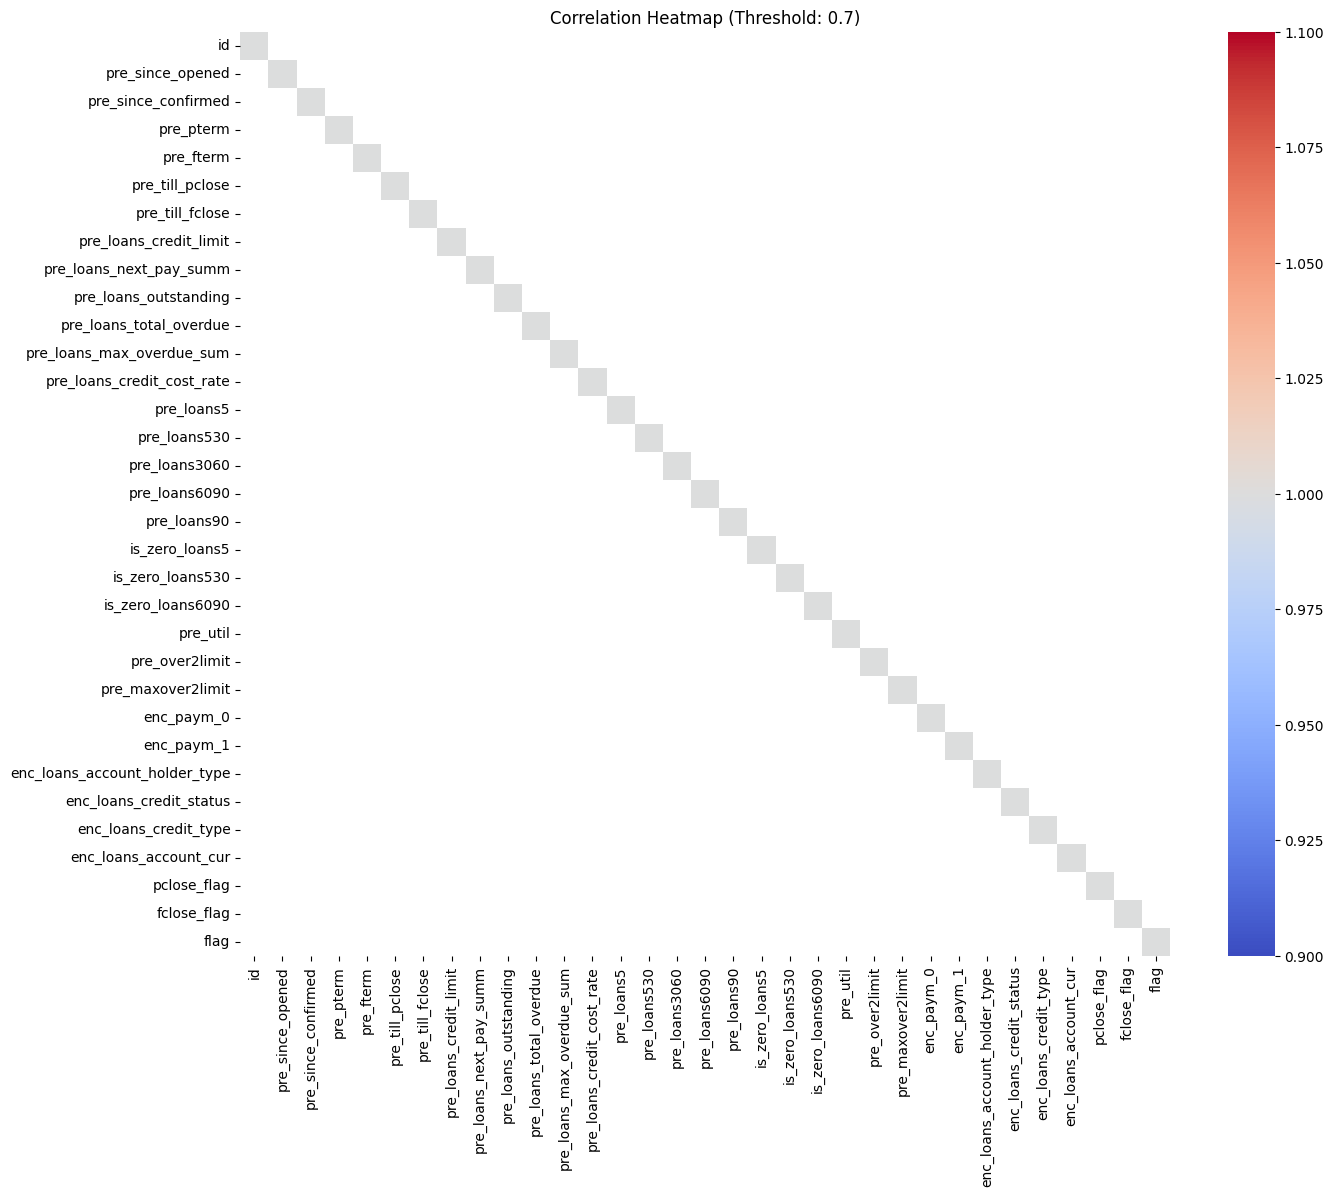

In [ ]:
# Установка порога корреляции
threshold = 0.7

# Создание маски для ячеек с корреляцией выше порога
mask = correlation_matrix.abs() > threshold

# Построение тепловой карты с учетом маски
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix[mask], annot=False, cmap='coolwarm', fmt=".2f")
plt.title(f'Correlation Heatmap (Threshold: {threshold})')
plt.show()


In [ ]:
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

# Предположим, что df содержит ваши данные, а "flag" является целевым столбцом
X = df.drop(columns=["flag"])
y = df["flag"]

# Создание моделей
lr = LogisticRegression()
rf = RandomForestClassifier()
gbt = GradientBoostingClassifier()

# Оценка моделей с использованием перекрёстной проверки
lr_scores = cross_val_score(lr, X, y, cv=5, scoring="roc_auc")
rf_scores = cross_val_score(rf, X, y, cv=5, scoring="roc_auc")
gbt_scores = cross_val_score(gbt, X, y, cv=5, scoring="roc_auc")

# Средняя оценка по перекрёстной проверке
lr_mean_score = lr_scores.mean()
rf_mean_score = rf_scores.mean()
gbt_mean_score = gbt_scores.mean()

# Вывод результатов
print("Средняя оценка для Логистической регрессии:", lr_mean_score)
print("Средняя оценка для Случайного леса:", rf_mean_score)
print("Средняя оценка для GBT:", gbt_mean_score)

# Выбор лучшей модели
best_model_auc = max(lr_mean_score, rf_mean_score, gbt_mean_score)
if best_model_auc == lr_mean_score:
    best_model = "Логистическая регрессия"
elif best_model_auc == rf_mean_score:
    best_model = "Случайный лес"
else:
    best_model = "GBT"

print("Лучшая модель:", best_model)


Средняя оценка для Логистической регрессии: 0.8693467985275778
Средняя оценка для Случайного леса: 0.7439480998333561
Средняя оценка для GBT: 0.7290456674618557
Лучшая модель: Логистическая регрессия


In [ ]:
# Импорт необходимых библиотек
from sklearn.model_selection import train_test_split

# Определение признаков (X) и целевой переменной (y)
X = df.drop(columns=['flag'])  # Исключаем столбец с целевой переменной
y = df['flag']

# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Вывод размеров обучающего и тестового наборов
print("Размер обучающего набора:", X_train.shape)
print("Размер тестового набора:", X_test.shape)


Размер обучающего набора: (162749, 32)
Размер тестового набора: (28721, 32)


In [ ]:
# Импорт модели линейной регрессии
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Создание модели линейной регрессии
lr = LinearRegression()

# Обучение модели на обучающем наборе
lr.fit(X_train, y_train)

# Прогнозы на тестовом наборе
y_pred = lr.predict(X_test)

# Оценка качества модели
accuracy = accuracy_score(y_test, y_pred.round())
precision = precision_score(y_test, y_pred.round())
recall = recall_score(y_test, y_pred.round())
f1 = f1_score(y_test, y_pred.round())
roc_auc = roc_auc_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred.round())

# Вывод метрик оценки качества модели
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("ROC AUC score:", roc_auc)
print("Confusion matrix:")
print(conf_matrix)


Accuracy: 0.8003203231085269
Precision: 0.8659776202272145
Recall: 0.7087527964205816
F1-score: 0.7795163584637269
ROC AUC score: 0.8733651452602484
Confusion matrix:
[[12848  1569]
 [ 4166 10138]]


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

# Создание модели логистической регрессии
model = LogisticRegression()

# Применение кросс-валидации с 5 фолдами
scores = cross_val_score(model, X, y, cv=5)

# Вывод результатов кросс-валидации
print("Средняя оценка кросс-валидации:", scores.mean())


Средняя оценка кросс-валидации: 0.582932052018593


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Пример загрузки данных из DataFrame
# Здесь df - ваш DataFrame
# Предположим, что у вас есть столбец 'flag' с метками классов и другие признаки
# Вам также может потребоваться выполнить предварительную обработку данных, такую как масштабирование

# Предварительная обработка данных
scaler = StandardScaler()
X = scaler.fit_transform(df.drop('flag', axis=1).values)
y = df['flag'].values

# Разделение на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Преобразование данных в тензоры PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Определение архитектуры нейронной сети
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 64)  # Входной слой
        self.relu = nn.ReLU()  # Функция активации ReLU
        self.fc2 = nn.Linear(64, 1)  # Выходной слой

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Создание экземпляра модели
model = NeuralNetwork()

# Определение функции потерь и оптимизатора
criterion = nn.BCEWithLogitsLoss()  # Бинарная кросс-энтропия
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Оптимизатор Adam

# Обучение модели
num_epochs = 250
for epoch in range(num_epochs):
    model.train()  # Перевод модели в режим обучения
    optimizer.zero_grad()  # Обнуление градиентов
    outputs = model(X_train_tensor)  # Предсказание на обучающем наборе
    loss = criterion(outputs, y_train_tensor.view(-1, 1))  # Вычисление функции потерь
    loss.backward()  # Обратное распространение ошибки
    optimizer.step()  # Обновление весов

    # Вывод промежуточных результатов
    if (epoch+1) % 1 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Оценка модели
model.eval()  # Перевод модели в режим оценки
with torch.no_grad():
    outputs = model(X_test_tensor)  # Предсказание на тестовом наборе
    predicted = torch.round(torch.sigmoid(outputs))  # Преобразование предсказанных значений в бинарные

    # Вывод результатов оценки
    accuracy = (predicted == y_test_tensor.view(-1, 1)).sum().item() / len(y_test_tensor)
    print(f'Accuracy: {accuracy:.4f}')


Epoch [1/250], Loss: 0.7109
Epoch [2/250], Loss: 0.7076
Epoch [3/250], Loss: 0.7045
Epoch [4/250], Loss: 0.7014
Epoch [5/250], Loss: 0.6984
Epoch [6/250], Loss: 0.6955
Epoch [7/250], Loss: 0.6927
Epoch [8/250], Loss: 0.6900
Epoch [9/250], Loss: 0.6873
Epoch [10/250], Loss: 0.6847
Epoch [11/250], Loss: 0.6822
Epoch [12/250], Loss: 0.6797
Epoch [13/250], Loss: 0.6773
Epoch [14/250], Loss: 0.6750
Epoch [15/250], Loss: 0.6727
Epoch [16/250], Loss: 0.6704
Epoch [17/250], Loss: 0.6682
Epoch [18/250], Loss: 0.6660
Epoch [19/250], Loss: 0.6639
Epoch [20/250], Loss: 0.6618
Epoch [21/250], Loss: 0.6597
Epoch [22/250], Loss: 0.6576
Epoch [23/250], Loss: 0.6556
Epoch [24/250], Loss: 0.6536
Epoch [25/250], Loss: 0.6516
Epoch [26/250], Loss: 0.6496
Epoch [27/250], Loss: 0.6476
Epoch [28/250], Loss: 0.6457
Epoch [29/250], Loss: 0.6437
Epoch [30/250], Loss: 0.6418
Epoch [31/250], Loss: 0.6399
Epoch [32/250], Loss: 0.6380
Epoch [33/250], Loss: 0.6361
Epoch [34/250], Loss: 0.6342
Epoch [35/250], Loss: 0

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Определение модели
model = LogisticRegression()

# Определение сетки параметров для перебора
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}

# Создание экземпляра GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')

# Обучение модели на обучающих данных
grid_search.fit(X_train, y_train)

# Вывод лучших параметров и оценки
print("Наилучшие параметры:", grid_search.best_params_)
print("Точность на тестовом наборе:", grid_search.best_score_)


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solve

Наилучшие параметры: {'C': 1, 'penalty': 'l2'}
Точность на тестовом наборе: 0.8156173304178924


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Создание модели логистической регрессии с наилучшими параметрами
lr_best = LogisticRegression(C=1, penalty='l2')

# Обучение модели на всем тренировочном наборе данных
lr_best.fit(X_train, y_train)

# Предсказание классов на тестовом наборе данных
y_pred = lr_best.predict(X_test)

# Вычисление метрик
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Вывод результатов
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("ROC AUC score:", roc_auc)
print("Confusion matrix:")
print(conf_matrix)


Accuracy: 0.4980327983008948
Precision: 0.4980327983008948
Recall: 1.0
F1-score: 0.6649157466589193
ROC AUC score: 0.5
Confusion matrix:
[[    0 14417]
 [    0 14304]]


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

# Создание модели логистической регрессии с оптимальными параметрами
model = LogisticRegression(C=1, penalty='l2')

# Применение кросс-валидации с 5 фолдами
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

# Вывод среднего значения оценок кросс-валидации
print("Средняя оценка кросс-валидации:", cv_scores.mean())


Средняя оценка кросс-валидации: 0.5003471603890228


In [ ]:
rest_of_data_df.show()

+-----+---+----------------+-------------------+---------+---------+---------------+---------------+----------------------+-----------------------+---------------------+-----------------------+-------------------------+--------------------------+----------+------------+-------------+-------------+-----------+--------------+----------------+-----------------+-----------------+---------------+--------+--------------+-----------------+------------+------------------+---------------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------------------------+-----------------------+---------------------+---------------------+-----------+-----------+----+
|   id| rn|pre_since_opened|pre_since_confirmed|pre_pterm|pre_fterm|pre_till_pclose|pre_till

In [ ]:
# Импорт необходимых библиотек
from pyspark.sql.functions import rand

# Выбор 1% данных из rest_of_data_df
sampled_rest_of_data_df = rest_of_data_df.sample(False, 0.01, seed=42)

# Преобразование выборки в Pandas DataFrame
sampled_rest_of_data_pandas = sampled_rest_of_data_df.toPandas()


In [ ]:
sampled_rest_of_data_pandas['flag'].value_counts()

0    26398
1      956
Name: flag, dtype: int64

In [ ]:
my_test = sampled_rest_of_data_pandas.drop(columns=correlated_list)

In [ ]:
my_test = my_test.drop(columns=_)

In [ ]:
my_test

,id,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,pre_loans_outstanding,...,pre_maxover2limit,enc_paym_0,enc_paym_1,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag,flag
0,283398,10,4,6,5,0,13,11,2,3,...,17,0,0,1,3,3,1,0,0,0
1,363614,18,8,15,2,5,10,12,2,3,...,17,0,0,1,3,1,1,0,0,1
2,461839,16,11,6,8,0,11,2,2,3,...,17,0,0,3,3,0,1,0,1,0
3,807896,15,14,14,15,3,1,7,2,3,...,17,0,0,1,3,4,1,0,0,0
4,1399697,10,8,11,13,5,10,4,2,3,...,4,0,0,1,3,3,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27349,249983,1,2,17,8,8,11,3,2,4,...,17,0,1,1,2,3,1,0,1,0
27350,353666,3,17,9,0,15,14,3,2,3,...,17,0,0,1,3,4,1,0,0,0
27351,777996,13,9,3,5,13,3,5,1,3,...,17,0,0,1,3,4,1,0,0,0
27352,846950,9,9,2,10,8,8,8,4,2,...,17,0,0,1,2,4,1,0,0,0


In [ ]:
X_test = my_test.drop(columns=['flag'])
y_test = my_test['flag']


In [ ]:
y_test

0        0
1        1
2        0
3        0
4        0
        ..
27349    0
27350    0
27351    0
27352    0
27353    1
Name: flag, Length: 27354, dtype: int32

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# # Создание модели логистической регрессии с наилучшими параметрами
# lr_best = LogisticRegression(C=1, penalty='l2')

# # Обучение модели на всем тренировочном наборе данных
# lr_best.fit(X_train, y_train)

# Предсказание классов на тестовом наборе данных
y_pred = lr_best.predict(X_test)

# Вычисление метрик
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Вывод результатов
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("ROC AUC score:", roc_auc)
print("Confusion matrix:")
print(conf_matrix)


Accuracy: 0.034949184762740365
Precision: 0.034949184762740365
Recall: 1.0
F1-score: 0.06753797244789826
ROC AUC score: 0.5
Confusion matrix:
[[    0 26398]
 [    0   956]]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Определяем пространство параметров для поиска
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'penalty': ['l1', 'l2']}

# Создаем модель
lr = LogisticRegression()

# Создаем объект GridSearchCV
grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='accuracy')

# Обучаем модель
grid_search.fit(X_train, y_train)

# Выводим лучшие параметры
print("Наилучшие параметры:", grid_search.best_params_)

# Оцениваем производительность модели на тестовом наборе
accuracy = grid_search.score(X_test, y_test)
print("Точность на тестовом наборе:", accuracy)


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solve

Наилучшие параметры: {'C': 1, 'penalty': 'l2'}
Точность на тестовом наборе: 0.034949184762740365


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


### Исследования 2

In [ ]:
# Импорт библиотеки
from pyspark.sql.functions import col

# Удаление столбцов из списка correlated_list
for column in correlated_list:
    rest_of_data_df = rest_of_data_df.drop(col(column))


In [ ]:
# Импорт библиотеки
from pyspark.sql.functions import col

# Удаление столбцов из списка correlated_list
for column in _:
    rest_of_data_df = rest_of_data_df.drop(col(column))

In [ ]:
rest_of_data_df.columns

['id',
 'pre_since_opened',
 'pre_since_confirmed',
 'pre_pterm',
 'pre_fterm',
 'pre_till_pclose',
 'pre_till_fclose',
 'pre_loans_credit_limit',
 'pre_loans_next_pay_summ',
 'pre_loans_outstanding',
 'pre_loans_total_overdue',
 'pre_loans_max_overdue_sum',
 'pre_loans_credit_cost_rate',
 'pre_loans5',
 'pre_loans530',
 'pre_loans3060',
 'pre_loans6090',
 'pre_loans90',
 'is_zero_loans5',
 'is_zero_loans530',
 'is_zero_loans6090',
 'pre_util',
 'pre_over2limit',
 'pre_maxover2limit',
 'enc_paym_0',
 'enc_paym_1',
 'enc_loans_account_holder_type',
 'enc_loans_credit_status',
 'enc_loans_credit_type',
 'enc_loans_account_cur',
 'pclose_flag',
 'fclose_flag',
 'flag']

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Создание объекта SparkSession
spark = SparkSession.builder \
    .appName("YourApp") \
    .getOrCreate()

# Загрузка данных из файла или другого источника
data = rest_of_data_df

# Подготовка признаков (X) и целевой переменной (y) для обучающего и тестового наборов
assembler = VectorAssembler(inputCols=data.columns[:-1], outputCol="features")
data = assembler.transform(data).select("features", "flag")  # Замените 'целевой_столбец' на имя вашего целевого столбца

# Разделение данных на обучающий и тестовый наборы
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Создание и обучение модели случайного леса
rf_classifier = RandomForestClassifier(featuresCol='features', labelCol='flag', seed=42)
rf_model = rf_classifier.fit(train_data)

# Прогнозирование на тестовых данных
rf_predictions = rf_model.transform(test_data)

# Оценка производительности модели
evaluator = MulticlassClassificationEvaluator(labelCol='flag', predictionCol='prediction', metricName='accuracy')
accuracy = evaluator.evaluate(rf_predictions)

print("Accuracy:", accuracy)

# Завершение SparkSession
spark.stop()


Py4JJavaError: An error occurred while calling o2805.fit.
: java.lang.IllegalStateException: Cannot call methods on a stopped SparkContext.
This stopped SparkContext was created at:

org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
sun.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
sun.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:62)
sun.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
java.lang.reflect.Constructor.newInstance(Constructor.java:423)
py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
py4j.Gateway.invoke(Gateway.java:238)
py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
py4j.ClientServerConnection.run(ClientServerConnection.java:106)
java.lang.Thread.run(Thread.java:750)

The currently active SparkContext was created at:

org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
sun.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
sun.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:62)
sun.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
java.lang.reflect.Constructor.newInstance(Constructor.java:423)
py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
py4j.Gateway.invoke(Gateway.java:238)
py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
py4j.ClientServerConnection.run(ClientServerConnection.java:106)
java.lang.Thread.run(Thread.java:750)
         
	at org.apache.spark.SparkContext.assertNotStopped(SparkContext.scala:122)
	at org.apache.spark.SparkContext.broadcastInternal(SparkContext.scala:1659)
	at org.apache.spark.SparkContext.broadcast(SparkContext.scala:1644)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetFileFormat.buildReaderWithPartitionValues(ParquetFileFormat.scala:163)
	at org.apache.spark.sql.execution.FileSourceScanExec.inputRDD$lzycompute(DataSourceScanExec.scala:548)
	at org.apache.spark.sql.execution.FileSourceScanExec.inputRDD(DataSourceScanExec.scala:537)
	at org.apache.spark.sql.execution.FileSourceScanExec.doExecuteColumnar(DataSourceScanExec.scala:587)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeColumnar$1(SparkPlan.scala:222)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeQuery$1(SparkPlan.scala:246)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:243)
	at org.apache.spark.sql.execution.SparkPlan.executeColumnar(SparkPlan.scala:218)
	at org.apache.spark.sql.execution.InputAdapter.doExecuteColumnar(WholeStageCodegenExec.scala:521)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeColumnar$1(SparkPlan.scala:222)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeQuery$1(SparkPlan.scala:246)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:243)
	at org.apache.spark.sql.execution.SparkPlan.executeColumnar(SparkPlan.scala:218)
	at org.apache.spark.sql.execution.ColumnarToRowExec.inputRDDs(Columnar.scala:204)
	at org.apache.spark.sql.execution.ProjectExec.inputRDDs(basicPhysicalOperators.scala:51)
	at org.apache.spark.sql.execution.ProjectExec.inputRDDs(basicPhysicalOperators.scala:51)
	at org.apache.spark.sql.execution.SortExec.inputRDDs(SortExec.scala:132)
	at org.apache.spark.sql.execution.SampleExec.inputRDDs(basicPhysicalOperators.scala:345)
	at org.apache.spark.sql.execution.ProjectExec.inputRDDs(basicPhysicalOperators.scala:51)
	at org.apache.spark.sql.execution.WholeStageCodegenExec.doExecute(WholeStageCodegenExec.scala:751)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$execute$1(SparkPlan.scala:195)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeQuery$1(SparkPlan.scala:246)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:243)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:191)
	at org.apache.spark.sql.execution.DeserializeToObjectExec.doExecute(objects.scala:93)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$execute$1(SparkPlan.scala:195)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeQuery$1(SparkPlan.scala:246)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:243)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:191)
	at org.apache.spark.sql.execution.QueryExecution.toRdd$lzycompute(QueryExecution.scala:207)
	at org.apache.spark.sql.execution.QueryExecution.toRdd(QueryExecution.scala:206)
	at org.apache.spark.sql.Dataset.rdd$lzycompute(Dataset.scala:3849)
	at org.apache.spark.sql.Dataset.rdd(Dataset.scala:3847)
	at org.apache.spark.ml.util.Instrumentation.logDataset(Instrumentation.scala:62)
	at org.apache.spark.ml.classification.RandomForestClassifier.$anonfun$train$1(RandomForestClassifier.scala:141)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.classification.RandomForestClassifier.train(RandomForestClassifier.scala:139)
	at org.apache.spark.ml.classification.RandomForestClassifier.train(RandomForestClassifier.scala:47)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:114)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)


In [ ]:
from pyspark.ml.feature import VectorAssembler

# Разделение на train и test
train_df, test_df = rest_of_data_df.randomSplit([0.8, 0.2], seed=42)

# Выбор признаков для модели
feature_columns = rest_of_data_df.columns
feature_columns.remove('flag')  # Замените 'целевой_столбец' на имя вашего целевого столбца

# Подготовка признаков (X) и целевой переменной (y) для обучающего и тестового наборов
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

train_data = assembler.transform(train_df).select("features", "flag")  # Замените 'целевой_столбец' на имя вашего целевого столбца
test_data = assembler.transform(test_df).select("features", "flag")    # Замените 'целевой_столбец' на имя вашего целевого столбца


In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Создание экземпляра модели логистической регрессии
lr = LogisticRegression(featuresCol='features', labelCol='flag')

# Обучение модели на тренировочных данных
model = lr.fit(train_data)

# Прогнозирование на тестовых данных
predictions = model.transform(test_data)



Py4JJavaError: An error occurred while calling o2714.fit.
: java.lang.IllegalStateException: Cannot call methods on a stopped SparkContext.
This stopped SparkContext was created at:

org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
sun.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
sun.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:62)
sun.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
java.lang.reflect.Constructor.newInstance(Constructor.java:423)
py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
py4j.Gateway.invoke(Gateway.java:238)
py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
py4j.ClientServerConnection.run(ClientServerConnection.java:106)
java.lang.Thread.run(Thread.java:750)

The currently active SparkContext was created at:

org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
sun.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
sun.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:62)
sun.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
java.lang.reflect.Constructor.newInstance(Constructor.java:423)
py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
py4j.Gateway.invoke(Gateway.java:238)
py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
py4j.ClientServerConnection.run(ClientServerConnection.java:106)
java.lang.Thread.run(Thread.java:750)
         
	at org.apache.spark.SparkContext.assertNotStopped(SparkContext.scala:122)
	at org.apache.spark.SparkContext.broadcastInternal(SparkContext.scala:1659)
	at org.apache.spark.SparkContext.broadcast(SparkContext.scala:1644)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetFileFormat.buildReaderWithPartitionValues(ParquetFileFormat.scala:163)
	at org.apache.spark.sql.execution.FileSourceScanExec.inputRDD$lzycompute(DataSourceScanExec.scala:548)
	at org.apache.spark.sql.execution.FileSourceScanExec.inputRDD(DataSourceScanExec.scala:537)
	at org.apache.spark.sql.execution.FileSourceScanExec.doExecuteColumnar(DataSourceScanExec.scala:587)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeColumnar$1(SparkPlan.scala:222)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeQuery$1(SparkPlan.scala:246)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:243)
	at org.apache.spark.sql.execution.SparkPlan.executeColumnar(SparkPlan.scala:218)
	at org.apache.spark.sql.execution.InputAdapter.doExecuteColumnar(WholeStageCodegenExec.scala:521)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeColumnar$1(SparkPlan.scala:222)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeQuery$1(SparkPlan.scala:246)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:243)
	at org.apache.spark.sql.execution.SparkPlan.executeColumnar(SparkPlan.scala:218)
	at org.apache.spark.sql.execution.ColumnarToRowExec.inputRDDs(Columnar.scala:204)
	at org.apache.spark.sql.execution.SortExec.inputRDDs(SortExec.scala:132)
	at org.apache.spark.sql.execution.SampleExec.inputRDDs(basicPhysicalOperators.scala:345)
	at org.apache.spark.sql.execution.ProjectExec.inputRDDs(basicPhysicalOperators.scala:51)
	at org.apache.spark.sql.execution.ProjectExec.inputRDDs(basicPhysicalOperators.scala:51)
	at org.apache.spark.sql.execution.WholeStageCodegenExec.doExecute(WholeStageCodegenExec.scala:751)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$execute$1(SparkPlan.scala:195)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeQuery$1(SparkPlan.scala:246)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:243)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:191)
	at org.apache.spark.sql.execution.DeserializeToObjectExec.doExecute(objects.scala:93)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$execute$1(SparkPlan.scala:195)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeQuery$1(SparkPlan.scala:246)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:243)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:191)
	at org.apache.spark.sql.execution.QueryExecution.toRdd$lzycompute(QueryExecution.scala:207)
	at org.apache.spark.sql.execution.QueryExecution.toRdd(QueryExecution.scala:206)
	at org.apache.spark.sql.Dataset.rdd$lzycompute(Dataset.scala:3849)
	at org.apache.spark.sql.Dataset.rdd(Dataset.scala:3847)
	at org.apache.spark.ml.util.Instrumentation.logDataset(Instrumentation.scala:62)
	at org.apache.spark.ml.classification.LogisticRegression.$anonfun$train$1(LogisticRegression.scala:499)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.classification.LogisticRegression.train(LogisticRegression.scala:497)
	at org.apache.spark.ml.classification.LogisticRegression.train(LogisticRegression.scala:287)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:114)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)


In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
# Создание объекта BinaryClassificationEvaluator для оценки бинарной классификации
evaluator = BinaryClassificationEvaluator(labelCol='flag', rawPredictionCol='rawPrediction', metricName='areaUnderROC')

# Вычисление ROC AUC
roc_auc = evaluator.evaluate(predictions)
print("ROC AUC:", roc_auc)

# Создание объекта MulticlassClassificationEvaluator для оценки мультиклассовой классификации
evaluator_multi = MulticlassClassificationEvaluator(labelCol='flag', predictionCol='prediction', metricName='f1')

# Вычисление F1-меры
f1_score = evaluator_multi.evaluate(predictions)
print("F1-score:", f1_score)

# Остановка сессии Spark
spark.stop()

Py4JJavaError: An error occurred while calling o2755.evaluate.
: java.lang.IllegalStateException: Cannot call methods on a stopped SparkContext.
This stopped SparkContext was created at:

org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
sun.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
sun.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:62)
sun.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
java.lang.reflect.Constructor.newInstance(Constructor.java:423)
py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
py4j.Gateway.invoke(Gateway.java:238)
py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
py4j.ClientServerConnection.run(ClientServerConnection.java:106)
java.lang.Thread.run(Thread.java:750)

The currently active SparkContext was created at:

org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
sun.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
sun.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:62)
sun.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
java.lang.reflect.Constructor.newInstance(Constructor.java:423)
py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
py4j.Gateway.invoke(Gateway.java:238)
py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
py4j.ClientServerConnection.run(ClientServerConnection.java:106)
java.lang.Thread.run(Thread.java:750)
         
	at org.apache.spark.SparkContext.assertNotStopped(SparkContext.scala:122)
	at org.apache.spark.SparkContext.broadcastInternal(SparkContext.scala:1659)
	at org.apache.spark.SparkContext.broadcast(SparkContext.scala:1644)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetFileFormat.buildReaderWithPartitionValues(ParquetFileFormat.scala:163)
	at org.apache.spark.sql.execution.FileSourceScanExec.inputRDD$lzycompute(DataSourceScanExec.scala:548)
	at org.apache.spark.sql.execution.FileSourceScanExec.inputRDD(DataSourceScanExec.scala:537)
	at org.apache.spark.sql.execution.FileSourceScanExec.doExecuteColumnar(DataSourceScanExec.scala:587)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeColumnar$1(SparkPlan.scala:222)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeQuery$1(SparkPlan.scala:246)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:243)
	at org.apache.spark.sql.execution.SparkPlan.executeColumnar(SparkPlan.scala:218)
	at org.apache.spark.sql.execution.InputAdapter.doExecuteColumnar(WholeStageCodegenExec.scala:521)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeColumnar$1(SparkPlan.scala:222)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeQuery$1(SparkPlan.scala:246)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:243)
	at org.apache.spark.sql.execution.SparkPlan.executeColumnar(SparkPlan.scala:218)
	at org.apache.spark.sql.execution.ColumnarToRowExec.inputRDDs(Columnar.scala:204)
	at org.apache.spark.sql.execution.SortExec.inputRDDs(SortExec.scala:132)
	at org.apache.spark.sql.execution.SampleExec.inputRDDs(basicPhysicalOperators.scala:345)
	at org.apache.spark.sql.execution.ProjectExec.inputRDDs(basicPhysicalOperators.scala:51)
	at org.apache.spark.sql.execution.ProjectExec.inputRDDs(basicPhysicalOperators.scala:51)
	at org.apache.spark.sql.execution.WholeStageCodegenExec.doExecute(WholeStageCodegenExec.scala:751)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$execute$1(SparkPlan.scala:195)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeQuery$1(SparkPlan.scala:246)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:243)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:191)
	at org.apache.spark.sql.execution.DeserializeToObjectExec.doExecute(objects.scala:93)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$execute$1(SparkPlan.scala:195)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeQuery$1(SparkPlan.scala:246)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:243)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:191)
	at org.apache.spark.sql.execution.QueryExecution.toRdd$lzycompute(QueryExecution.scala:207)
	at org.apache.spark.sql.execution.QueryExecution.toRdd(QueryExecution.scala:206)
	at org.apache.spark.sql.Dataset.rdd$lzycompute(Dataset.scala:3849)
	at org.apache.spark.sql.Dataset.rdd(Dataset.scala:3847)
	at org.apache.spark.ml.evaluation.BinaryClassificationEvaluator.getMetrics(BinaryClassificationEvaluator.scala:131)
	at org.apache.spark.ml.evaluation.BinaryClassificationEvaluator.evaluate(BinaryClassificationEvaluator.scala:99)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)


In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression

# Создание экземпляра модели логистической регрессии
lr = LogisticRegression(featuresCol='features', labelCol='flag')

# Создание сетки параметров для настройки
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# Создание оценщика кросс-валидации
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol='flag'),
                          numFolds=5)

# Запуск кросс-валидации для настройки параметров
cvModel = crossval.fit(train_data)

# Получение наилучшей модели
best_model = cvModel.bestModel

# Оценка производительности на тестовых данных
predictions = best_model.transform(test_data)
evaluator = BinaryClassificationEvaluator(labelCol='flag')
roc_auc = evaluator.evaluate(predictions)

print("ROC AUC на тестовых данных:", roc_auc)


AssertionError: 

In [ ]:
model.eval()  # Перевод модели в режим оценки
with torch.no_grad():
    outputs = model(X_test_tensor)  # Предсказание на тестовом наборе
    predicted = torch.round(torch.sigmoid(outputs))  # Преобразование предсказанных значений в бинарные

    # Оценка точности модели
    accuracy = (predicted == y_test_tensor.view(-1, 1)).sum().item() / len(y_test_tensor)
    print(f'Accuracy: {accuracy:.4f}')


Accuracy: 0.8309


In [ ]:
# Предположим, что у вас есть новые данные new_data, которые вы хотите проверить
# Предварительная обработка новых данных (например, масштабирование)
new_data_scaled = scaler.transform(X_test)

# Преобразование новых данных в тензоры PyTorch
new_data_tensor = torch.tensor(new_data_scaled, dtype=torch.float32)

# Предсказание на новых данных
model.eval()  # Перевод модели в режим оценки
with torch.no_grad():
    outputs = model(new_data_tensor)  # Предсказание на новых данных
    predicted = torch.round(torch.sigmoid(outputs))  # Преобразование предсказанных значений в бинарные

# Вывод результатов прогнозирования
print("Predicted classes:", predicted)


Predicted classes: tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [1.],
        [1.]])


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [ ]:
from sklearn.metrics import accuracy_score

# Вычисление точности модели
accuracy = accuracy_score(y_test, predicted)
print("Accuracy:", accuracy)


Accuracy: 0.27356145353513195


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Создание и обучение модели случайного леса
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Прогнозирование на тестовых данных
rf_predictions = rf_model.predict(X_test)

# Вычисление метрик оценки модели
accuracy = accuracy_score(y_test, rf_predictions)
precision = precision_score(y_test, rf_predictions)
recall = recall_score(y_test, rf_predictions)
f1 = f1_score(y_test, rf_predictions)

# Вывод метрик оценки модели
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Accuracy: 0.8586400194979283
Precision: 0.8524635287641068
Recall: 0.8660514541387024
F1-score: 0.8592037730614509


In [ ]:
# Прогнозирование на новых данных
new_predictions = rf_model.predict(X_test)

# Вычисление метрик оценки модели на новых данных
new_accuracy = accuracy_score(y_test, new_predictions)
new_precision = precision_score(y_test, new_predictions)
new_recall = recall_score(y_test, new_predictions)
new_f1 = f1_score(y_test, new_predictions)

# Вывод метрик оценки модели на новых данных
print("New Accuracy:", new_accuracy)
print("New Precision:", new_precision)
print("New Recall:", new_recall)
print("New F1-score:", new_f1)


New Accuracy: 0.1925860934415442
New Precision: 0.040572273438858934
New Recall: 0.9759414225941423
New F1-score: 0.0779058116232465
